In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, get_context_length, get_generated_text

In [3]:
notebook_login()

## Importing models

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# tokenizer = AutoTokenizer.from_pretrained(
#     "mistralai/Mistral-7B-Instruct-v0.1",
#     cache_dir = "/Data"    
# )

# tunned_model = AutoModelForCausalLM.from_pretrained(
#     "mistralai/Mistral-7B-Instruct-v0.1",
#     quantization_config = quantization_config,
#     device_map="auto",
#     attn_implementation="eager",
#     cache_dir = "/Data" 
# )


tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    cache_dir = "/Data"    
)

tunned_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data" 
)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

## Getting dataset

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

df = load_dataset("stas/openwebtext-10k", cache_dir="/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))

In [6]:
DELTA_ATTENTION = None
instruction = None
tokens = None

def hook(module, input, output):

    if input[0].shape[1] == 1:
        return

    specific_token_ids = tokenizer(
        instruction,
        return_tensors="pt"
    )['input_ids']

    mask = torch.isin(tokens['input_ids'], specific_token_ids)

    instruction_size = specific_token_ids[1:].size(1)
    token_index_in_text = torch.nonzero(mask.squeeze())\
        [2:instruction_size]\
        .squeeze()

    hidden_states = input[0]
    bsz, q_len, _ = hidden_states.size()
    # qkT, value_states = helper\
    #     .get_attention_before_softmax(module, input, output)
    attention_mask = deepcopy(input[1])
    position_ids = input[2]
    past_key_value = input[3]
    cache_position = input[6]

    # pdb.set_trace()

    # print(attention_mask.max())

    attention_mask[:,:,:,token_index_in_text] += DELTA_ATTENTION

    query_states = module.q_proj(hidden_states)
    key_states = module.k_proj(hidden_states)
    value_states = module.v_proj(hidden_states)

    query_states = query_states.view(bsz, q_len, module.num_heads, module.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, module.num_key_value_heads, module.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, module.num_key_value_heads, module.head_dim).transpose(1, 2)

    cos, sin = module.rotary_emb(value_states, position_ids)
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

    key_states = repeat_kv(key_states, module.num_key_value_groups)
    value_states = repeat_kv(value_states, module.num_key_value_groups)

    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(module.head_dim)

    if attention_mask is not None:  # no matter the length, we just slice it
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
    attn_weights = nn.functional.dropout(attn_weights, p=module.attention_dropout, training=module.training)
    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, module.num_heads, q_len, module.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, module.num_heads, q_len, module.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.view(bsz, q_len, -1)
    attn_output = module.o_proj(attn_output)

    assert (attn_output.shape == output[0].shape)
    assert (attn_output!=output[0]).any()

    return attn_output, None, output[2]

## Using raw model

In [7]:
# for module_name, module in tunned_model.named_modules():
    
#     if module_name.endswith("0.self_attn"):
#         module.register_forward_hook(hook)

In [8]:
instruction = "Summarize in french"
df["context_length"] = (instruction + '\n' +df["text"])\
    .apply(lambda x: get_context_length(x, tokenizer))

In [9]:
samples_df = df.query("context_length > 2500 & context_length < 3000")\
    .sample(5, random_state = 42)

instructions = [
    "Summarize in french: ",
    "Important: Summarize in french: ",
    "You must summarize the following text in french: "
]

new_samples = []
for instruction in instructions:
    new_samples_df = samples_df.copy()

    new_samples_df["text"] = instruction + " \n " + new_samples_df["text"]
    new_samples_df["instruction"] = instruction
    new_samples.append(new_samples_df)

new_samples_df = pd.concat(new_samples)

## Generation

5 examples, 3 instructions, 50 sampling

In [10]:
results = dict()
for idx, row in samples_df.iterrows():
    results[idx] = {}
    results[idx]["base_text"] = row["text"]

In [14]:
DELTA_ATTENTION = 0
n_times_generation = 50
decoded = None
for generation_epoch in range(n_times_generation):
    count = 0

    t = tqdm(enumerate(new_samples_df.iterrows()), total = len(new_samples_df))
    for i, (idx, row) in t:

        prompt = row["text"]
        instruction = row['instruction']
        message = [ {"role": "user", "content": prompt}]

        template = tokenizer.apply_chat_template(
            message,
            tokenize= False
        )

        tokens = tokenizer(
            template,
            return_tensors = 'pt'
        )

        clear_output()

        if decoded is not None:

            print(f'''
                generating text...
                sample idx = {i}
                context_length = {tokens['input_ids'].shape}
                instruction = {instruction}
                generation_epoch = {generation_epoch}
                last generated text = {decoded[0].split("<|end_header_id|>") [1]}
                '''
            )

        else:
            print(f'''
                generating text...
                sample idx = {i}
                context_length = {tokens['input_ids'].shape}
                instruction = {instruction}
                generation_epoch = {generation_epoch}
                '''
            )

        generated_ids = tunned_model.generate(
            tokens['input_ids'].to('cuda'),
            # attention_mask = tokens['attention_mask'].to("cuda"),
            max_new_tokens = 30,
            do_sample = True,
            # temperature = 1.
        )

        decoded = tokenizer.batch_decode(generated_ids)

        print(f'''
            generated text : {decoded[0].split("<|end_header_id|>") [1]}
            '''
        )

        if not f"epoch {generation_epoch}" in results[idx]:
            results[idx][f"epoch {generation_epoch}"] = {}

        results[idx][f"epoch {generation_epoch}"][instruction] = decoded

dir = "data"

pd.DataFrame(results).to_pickle(f"{dir}/generated_delta={DELTA_ATTENTION}.pkl")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



                generating text...
                sample idx = 3
                context_length = torch.Size([1, 2691])
                instruction = Summarize in french: 
                generation_epoch = 0
                last generated text = 

Summarize in french:  
 NV Energy fights to keep rooftop solar from cutting into its profit

The future of solar energy in Nevada is at stake in a furious battle that likely won’t be resolved as the 2015 state legislative session nears an end next month.

Solar advocates, Nevada businesses and solar industry reps are pushing for more rooftop solar, saying it’s unfair to force consumers to remain chained to the grid and warning that the state could lose thousands of jobs if it doesn’t adapt. State utility NV Energy claims more household solar means increased prices for traditional customers who can’t or won’t install solar panels on their houses or businesses.

It comes down to money for both sides It’s all about dollars for both the solar 

 20%|██        | 3/15 [00:09<00:38,  3.22s/it]


KeyboardInterrupt: 

In [12]:
decoded

["<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nSummarize in french:  \n After a recent lecture about the singularity I got asked about its energy requirements. It is a good question. As my inquirer pointed out, humanity uses more and more energy and it generally has an environmental cost. If it keeps on growing exponentially, something has to give. And if there is a real singularity, how do you handle infinite energy demands?\n\nFirst I will look at current trends, then different models of the singularity.\n\nI will not deal directly with environmental costs here. They are relative to some idea of a value of an environment, and there are many ways to approach that question.\n\nCurrent trends\n\nCurrent computers are energy hogs. Currently general purpose computing consumes about one Petawatt-hour per year, with the entire world production somewhere above 22 Pwh. While large data centres may be obvious, the vast number of low-power devices may be an even

## Results analysis


In [16]:
# results_df = pd.read_pickle(f"{dir}/generated_delta={DELTA_ATTENTION}.pkl").T
results_df = pd.DataFrame(results).T

parsed_results_dict = dict()

for epoch in range(len(results_df.columns)-1):
    for (idx, result_epoch) in results_df.loc[:,f"epoch {epoch}"].items():
        s = pd.Series(result_epoch)\
            .apply(get_generated_text)\

        data = pd.DataFrame(s).T
        data.index = [idx]

        if not epoch in parsed_results_dict:
            parsed_results_dict[epoch] = []

        parsed_results_dict[epoch].append(data)

    parsed_results_dict[epoch] = pd.concat(parsed_results_dict[epoch])

In [17]:

all_dfs = []

for epoch in parsed_results_dict.keys():
    temp_df = pd.melt(
        parsed_results_dict[epoch].reset_index(),
        var_name = "instruction",
        value_name = "generated_text",
        id_vars = "index",
    )

    temp_df["is_french"] = temp_df["generated_text"].apply(lambda x: detect(x) == 'fr')

    temp_df["generation_epoch"] = epoch

    all_dfs.append(temp_df)

melted_df = pd.concat(all_dfs)

Text(0.5, 1.0, 'Setup: 5 different texts, 3 instructions, 50 generations each')

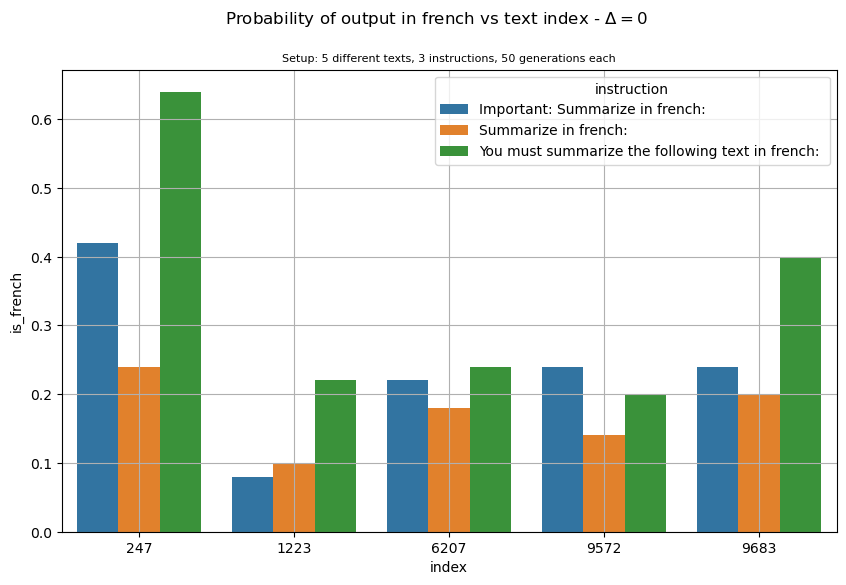

In [18]:
performance_per_index_per_instruction = melted_df\
    .groupby(["index", "instruction"])\
    .is_french\
    .mean()\
    .reset_index()

plt.figure(figsize = (10,6))

sns.barplot(
    performance_per_index_per_instruction,
    y = "is_french",
    x = "index",
    hue = "instruction"
)

plt.grid()
plt.suptitle(rf"Probability of output in french vs text index - $\Delta= {DELTA_ATTENTION}$ ")
plt.title(
    f"Setup: {len(samples_df)} different texts, {len(instructions)} instructions, {n_times_generation} generations each",
    fontsize = 8
)

## Complete study

* 20 samples each interval of context length
* 10 generations each 
* 3 different instructions
* `max_new_tokens = 30`

In [19]:
chunks = []
for n in range (12):
    samples = df.query(f"context_length > {500*n} & context_length < {500*(n+1)}")\
        .sample(20, random_state = 42)
    
    chunks.append(samples)

study_df = pd.concat(chunks)\
    .sort_values("context_length", ascending = False)

In [20]:
instructions = [
    "Summarize in french: ",
    "Important: Summarize in french: ",
    "You must summarize the following text in french: "
]

new_samples = []
for instruction in instructions:
    new_samples_df = study_df.copy()

    new_samples_df["text"] = instruction + " \n " + new_samples_df["text"]
    new_samples_df["instruction"] = instruction
    new_samples.append(new_samples_df)

new_samples_df = pd.concat(new_samples)

In [21]:
results_complete_study = dict()
for idx, row in study_df.iterrows():
    results_complete_study[idx] = {}
    results_complete_study[idx]["base_text"] = row["text"]

In [24]:
DELTA_ATTENTION = 0
n_times_generation = 10
decoded = None
dir = "data/complete_study"

for generation_epoch in range(n_times_generation):
    count = 0

    t = tqdm(enumerate(new_samples_df.iterrows()), total = len(new_samples_df))
    for i, (idx, row) in t:

        prompt = row["text"]
        instruction = row['instruction']
        message = [ {"role": "user", "content": prompt}]

        template = tokenizer.apply_chat_template(
            message,
            tokenize= False
        )

        tokens = tokenizer(
            template,
            return_tensors = 'pt'
        )

        clear_output()

        if decoded is not None:

            print(f'''
                generating text...
                sample idx = {i}
                context_length = {tokens['input_ids'].shape}
                instruction = {instruction}
                generation_epoch = {generation_epoch}
                last generated text = {decoded[0].split("[/INST]") [1]}
                '''
            )

        else:
            print(f'''
                generating text...
                sample idx = {i}
                context_length = {tokens['input_ids'].shape}
                instruction = {instruction}
                generation_epoch = {generation_epoch}
                '''
            )

        generated_ids = tunned_model.generate(
            tokens['input_ids'].to('cuda'),
            # attention_mask = tokens['attention_mask'].to("cuda"),
            max_new_tokens = 30,
            do_sample = True,
            # temperature = 1.
        )

        decoded = tokenizer.batch_decode(generated_ids)

        print(f'''
            generated text : {decoded[0].split("[/INST]") [1]}
            '''
        )

        if not f"epoch {generation_epoch}" in results_complete_study[idx]:
            results_complete_study[idx][f"epoch {generation_epoch}"] = {}

        results_complete_study[idx][f"epoch {generation_epoch}"][instruction] = decoded
    pd.DataFrame(results_complete_study).to_pickle(f"{dir}/checkpoints/generated_delta={DELTA_ATTENTION}.pkl")

pd.DataFrame(results_complete_study).to_pickle(f"{dir}/generated_delta={DELTA_ATTENTION}.pkl")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



                generating text...
                sample idx = 94
                context_length = torch.Size([1, 3667])
                instruction = Summarize in french: 
                generation_epoch = 2
                last generated text =  The update from the Dear Leader to their team in China is long and detailed, as they go through many topics related to the GameStick project.
                


 13%|█▎        | 94/720 [07:41<51:10,  4.91s/it]


KeyboardInterrupt: 